In [5]:
#Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random

#visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm


#tf libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing
# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

In [6]:
#helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
spices_data = 'D:\Spices_Clasification_update'
walk_through_dir(spices_data)

There are 26 directories and 0 images in 'D:\Spices_Clasification_update'.
There are 0 directories and 200 images in 'D:\Spices_Clasification_update\adas'.
There are 0 directories and 195 images in 'D:\Spices_Clasification_update\andaliman'.
There are 0 directories and 201 images in 'D:\Spices_Clasification_update\asam_jawa'.
There are 0 directories and 200 images in 'D:\Spices_Clasification_update\biji_ketumbar'.
There are 0 directories and 136 images in 'D:\Spices_Clasification_update\bukan_rempah'.
There are 0 directories and 200 images in 'D:\Spices_Clasification_update\bunga_lawang'.
There are 0 directories and 202 images in 'D:\Spices_Clasification_update\cengkeh'.
There are 0 directories and 215 images in 'D:\Spices_Clasification_update\daun_ketumbar'.
There are 0 directories and 206 images in 'D:\Spices_Clasification_update\daun_salam'.
There are 0 directories and 206 images in 'D:\Spices_Clasification_update\jahe'.
There are 0 directories and 190 images in 'D:\Spices_Clasifica

In [8]:
img_directory = Path(spices_data)
filepaths = list(img_directory.glob(r'**/*.JPG')) + list(img_directory.glob(r'**/*.jpg')) + list(img_directory.glob(r'**/*.png')) + list(img_directory.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [9]:
image_df

,Filepath,Label
0,D:\Spices_Clasification_update\adas\adas-001.jpg,adas
1,D:\Spices_Clasification_update\adas\adas-002.jpg,adas
2,D:\Spices_Clasification_update\adas\adas-003.jpg,adas
3,D:\Spices_Clasification_update\adas\adas-004.jpg,adas
4,D:\Spices_Clasification_update\adas\adas-005.jpg,adas
...,...,...
10285,D:\Spices_Clasification_update\kayu manis\Imag...,kayu manis
10286,D:\Spices_Clasification_update\kayu secang\Ima...,kayu secang
10287,D:\Spices_Clasification_update\kayu secang\Ima...,kayu secang
10288,D:\Spices_Clasification_update\kemiri\Image_1.png,kemiri


**VISUALIZE THE DATASET**

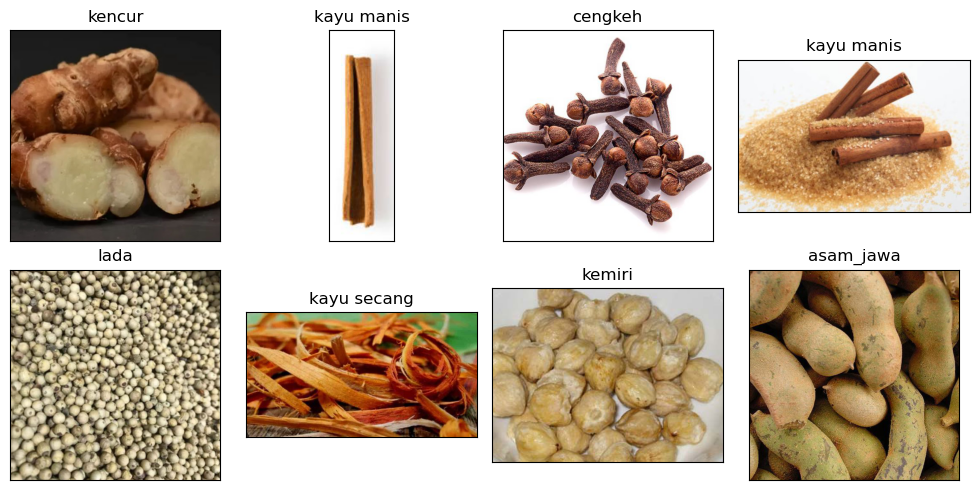

In [10]:
# Display 8 pictures of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 8)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 5),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = plt.imread(image_df['Filepath'].iloc[random_index[i]])
    ax.imshow(img)
    ax.set_title(image_df['Label'].iloc[random_index[i]])

plt.tight_layout()
plt.show()

In [11]:
#separate to training, validation, testing
training_dataset, testing_dataset = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [12]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v3.preprocess_input
)

In [13]:
training_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='training')

validation_images = train_generator.flow_from_dataframe(
dataframe = training_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=True,
seed=42,
subset='validation')

test_images = test_generator.flow_from_dataframe(
dataframe = testing_dataset,
x_col='Filepath',
y_col = 'Label',
target_size=(224,224),
color_mode='rgb',
class_mode='categorical',
batch_size=32,
shuffle=False)

Found 6586 validated image filenames belonging to 26 classes.
Found 1646 validated image filenames belonging to 26 classes.
Found 2058 validated image filenames belonging to 26 classes.


In [14]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224,224),
    layers.experimental.preprocessing.Rescaling(1./255),
])

augmented = keras.Sequential([
    preprocessing.RandomFlip("horizontal_and_vertical"),
    preprocessing.RandomZoom(0.3),
    preprocessing.RandomRotation(0.4),
    preprocessing.RandomWidth(0.3),
    preprocessing.RandomHeight(0.3)
], name="data_augmentation")

In [15]:
input_shape = (224,224,3)
Base_Model = tf.keras.applications.MobileNetV3Large(
input_shape=input_shape,
include_top = False,
    weights = 'imagenet',
    pooling='avg'
)
Base_Model.trainable = False

In [16]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=5,
                                                  restore_best_weights=True) # if val loss decreases for 3 epochs in a row, stop training

In [17]:
def build_model(base_model, num_classes):
    input = base_model.input
    x = resize_and_rescale(input)
    x = augmented(x)
    x = Dense(256,activation='relu')(base_model.output)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(64, activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(32, activation = 'relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes,activation='softmax')(x)
    model = Model(inputs=input, outputs=outputs)
    return model
model = build_model(Base_Model,26)
model.compile(
optimizer = Adam(0.0001),
loss='categorical_crossentropy',
metrics=['accuracy'])

history = model.fit(
    training_images,
    steps_per_epoch=len(training_images),
    validation_data=validation_images,
    validation_steps=len(validation_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs", "spices_classification")
    ]
)

Saving TensorBoard log files to: training_logs/spices_classification/20231205-085446
Epoch 1/100


206/206 [==============================] - 199s 895ms/step - loss: 3.3266 - accuracy: 0.0569 - val_loss: 3.0919 - val_accuracy: 0.2108
Epoch 2/100
206/206 [==============================] - 181s 879ms/step - loss: 3.1122 - accuracy: 0.1001 - val_loss: 2.8856 - val_accuracy: 0.3615
Epoch 3/100
206/206 [==============================] - 179s 870ms/step - loss: 2.9219 - accuracy: 0.1600 - val_loss: 2.5202 - val_accuracy: 0.4757
Epoch 4/100
206/206 [==============================] - 181s 878ms/step - loss: 2.6747 - accuracy: 0.2124 - val_loss: 2.1235 - val_accuracy: 0.5790
Epoch 5/100
206/206 [==============================] - 181s 879ms/step - loss: 2.4102 - accuracy: 0.2926 - val_loss: 1.7516 - val_accuracy: 0.6519
Epoch 6/100
206/206 [==============================] - 181s 875ms/step - loss: 2.1890 - accuracy: 0.3558 - val_loss: 1.4763 - val_accuracy: 0.7169
Epoch 7/100
206/206 [==========

In [18]:
results = model.evaluate(test_images, verbose=2)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

65/65 - 51s - loss: 0.1883 - accuracy: 0.9451 - 51s/epoch - 783ms/step
    Test Loss: 0.18832
Test Accuracy: 94.51%


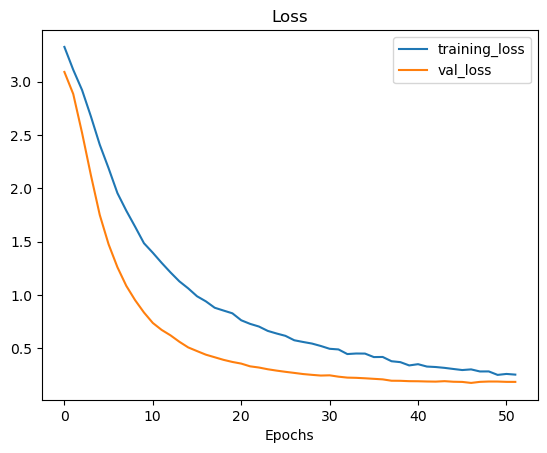

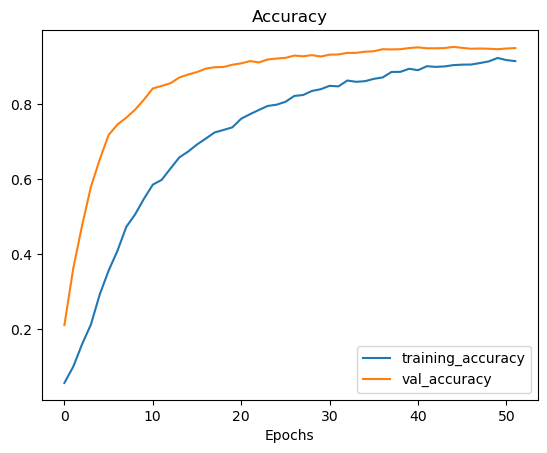

In [19]:
plot_loss_curves(history)

In [20]:
model.save('train_model_mobileNetV3_new2.h5')

C:\Users\Dany\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [29]:
 converter = tf.lite.TFLiteConverter.from_keras_model(model)
 tflite_model = converter.convert()

 with open('model.tflite_2', 'wb') as f:
   f.write(tflite_model)

In [21]:
history.history #Return Dictionary of history

{'loss': [3.3265609741210938,
  3.1122233867645264,
  2.9219281673431396,
  2.6746573448181152,
  2.4101614952087402,
  2.189012289047241,
  1.9559162855148315,
  1.791567087173462,
  1.6411070823669434,
  1.4863561391830444,
  1.3971500396728516,
  1.3023346662521362,
  1.2128857374191284,
  1.1293269395828247,
  1.0635377168655396,
  0.9893590807914734,
  0.9415530562400818,
  0.8816575407981873,
  0.8552616834640503,
  0.829408586025238,
  0.764151930809021,
  0.7305809259414673,
  0.7054874300956726,
  0.664552628993988,
  0.6401547193527222,
  0.6181562542915344,
  0.576747477054596,
  0.5606982707977295,
  0.5458836555480957,
  0.5231727361679077,
  0.4968033730983734,
  0.4908542037010193,
  0.4474674463272095,
  0.45252397656440735,
  0.4518278241157532,
  0.41911041736602783,
  0.42022639513015747,
  0.38016319274902344,
  0.3716110587120056,
  0.34080156683921814,
  0.35252678394317627,
  0.33027544617652893,
  0.32590144872665405,
  0.3179364502429962,
  0.3075105547904968,


In [22]:
#Recording History in json
import json
with open('train_hist_mobileNetV3_new2.json','w') as f:
  json.dump(history.history,f)

In [23]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [24]:
print("Validation set Accuracy: {} %".format(history.history['val_accuracy'][-1]*100))

Validation set Accuracy: 94.83596682548523 %


In [25]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (training_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

65/65 [==============================] - 35s 512ms/step
The first 5 predictions: ['kayu manis', 'lada', 'cengkeh', 'jahe', 'kayu manis']


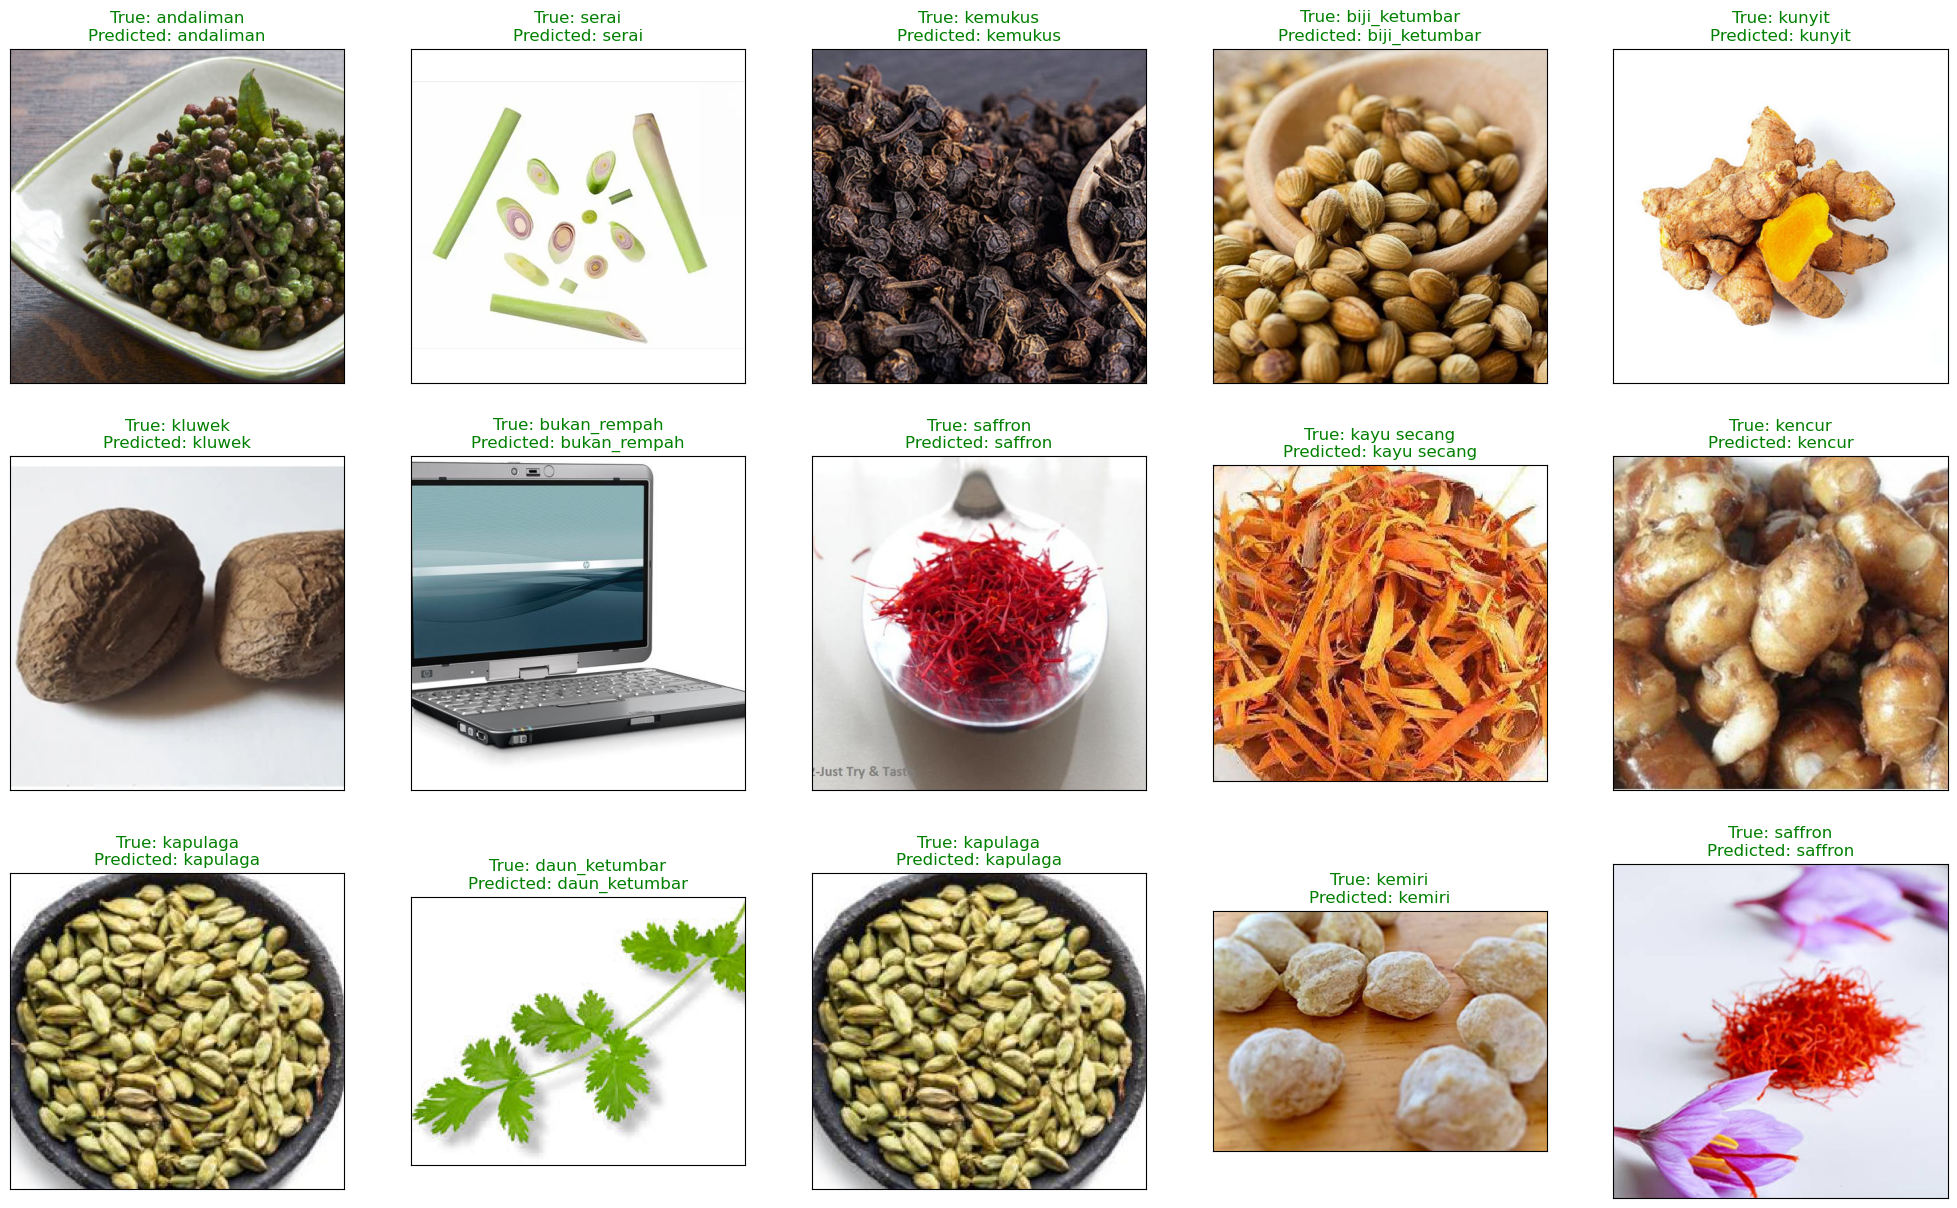

<Figure size 640x480 with 0 Axes>

In [26]:
  # Display 15 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(testing_dataset) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(testing_dataset.Filepath.iloc[random_index[i]]))
    if testing_dataset.Label.iloc[random_index[i]] == pred[random_index[i]]:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {testing_dataset.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

In [27]:
y_test = list(testing_dataset.Label)
print(classification_report(y_test, pred))

               precision    recall  f1-score   support

         adas       0.96      0.85      0.90        91
    andaliman       0.98      1.00      0.99        93
    asam_jawa       1.00      1.00      1.00        69
biji_ketumbar       0.92      0.83      0.88        84
 bukan_rempah       0.98      0.98      0.98        60
 bunga_lawang       0.97      0.97      0.97        73
      cengkeh       0.99      0.92      0.95        86
daun_ketumbar       0.97      0.97      0.97        80
   daun_salam       0.97      0.84      0.90        77
         jahe       0.91      0.96      0.93        90
       jinten       0.82      0.92      0.87        76
     kapulaga       0.93      0.95      0.94        83
   kayu manis       0.88      0.92      0.90        71
  kayu secang       1.00      1.00      1.00        68
       kemiri       0.79      0.84      0.82        76
      kemukus       0.93      1.00      0.96        96
       kencur       0.88      0.92      0.90        74
       kl

In [ ]:
#Convert to TF LITE
import tensorflow as tf
import pathlib

model = tf.keras.models.load_model('train_model_mobileNetV3.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Specify a file name for the TFLite model
tflite_model_file = pathlib.Path('D:\Indonesian_Spices\model_mobileNetV3.tflite')

# Save the TFLite model to a file
tflite_model_file.write_bytes(tflite_model)
